In [1]:
!pip install pandas scikit-learn matplotlib seaborn

In [2]:
!pip install transformers datasets

In [30]:
import pandas as pd

# CSV dosyasını oku
df = pd.read_csv("niyet_verisi.csv", encoding="windows-1254", sep=",")

# Veriye genel bakış
print(df.head())
print(df["label"].value_counts())


   id                                   text     label
0   1              "Bu ürünün fiyatı nedir?"   "bilgi"
1   2                 "Bugün hava çok güzel"   "bilgi"
2   3   "Yarın hangi saatlerde açıyorsunuz?"   "bilgi"
3   4       "Ürünümü nasıl iade edebilirim?"   "bilgi"
4   5    "Bu restoranda hangi yemekler var?"   "bilgi"
label
"bilgi"      5684
"şikayet"    5684
Name: count, dtype: int64


In [31]:
# Temizleme: ?şikayet gibi etiketleri düzelt
df["label"] = df["label"].str.replace("?", "", regex=False).str.strip()

In [32]:
import re
import nltk
from nltk.corpus import stopwords

# NLTK stopwords listesini indir (ilk seferde çalıştırman yeterli)
# nltk.download("stopwords")
# nltk.download("punkt")

# Türkçe stopwords listesi
turkce_stopwords = set(stopwords.words("turkish"))

# Daha kapsamlı emoji temizleme regex'i
def emojileri_temizle(metin):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # yüz ifadeleri
        u"\U0001F300-\U0001F5FF"  # sembol ve piktogramlar
        u"\U0001F680-\U0001F6FF"  # ulaşım ve harita sembolleri
        u"\U0001F1E0-\U0001F1FF"  # bayraklar
        u"\U00002700-\U000027BF"  # çeşitli semboller
        u"\U0001F900-\U0001F9FF"  # ek yüz ifadeleri
        u"\U0001FA70-\U0001FAFF"  # ek simgeler
        u"\U00002600-\U000026FF"  # hava ve astroloji sembolleri
        u"\U000025A0-\U00002BEF"  # geometrik şekiller ve simgeler
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', metin)

def temizle(metin):
    if not isinstance(metin, str):
        return ""  # Metin değilse boş döndür

    metin = metin.lower()  # küçük harfe çevir
    metin = re.sub(r"<.*?>", "", metin)  # HTML etiketlerini kaldır
    metin = re.sub(r"http\S+|www\.\S+", "", metin)  # URL'leri kaldır
    metin = emojileri_temizle(metin)  # emojileri temizle
    metin = re.sub(r"[^\w\s]", "", metin)  # noktalama işaretlerini kaldır
    metin = re.sub(r"\s+", " ", metin)  # fazla boşlukları sadeleştir

    # Stopwords çıkarımı
    kelimeler = metin.strip().split()
    kelimeler = [kelime for kelime in kelimeler if kelime not in turkce_stopwords]
    return " ".join(kelimeler)

In [33]:
from sklearn.model_selection import train_test_split

X = df["text"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

# NaN değerleri boş string ile doldur
X_train = X_train.fillna("")
X_test = X_test.fillna("")

vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\YIGITHAN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\YIGITHAN\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['birkac', 'birsey', 'cok', 'cunku', 'eger', 'hic', 'icin', 'nicin', 'sey', 'su', 'tum'] not in stop_words.
  warnings.warn(


🔧 max_features (kararlı): 14378
📦 Epoch 1/200
📈 Epoch 1 Accuracy: 0.9798
📦 Epoch 2/200
📈 Epoch 2 Accuracy: 0.9803
📦 Epoch 3/200
📈 Epoch 3 Accuracy: 0.9804
📦 Epoch 4/200
📈 Epoch 4 Accuracy: 0.9804
📦 Epoch 5/200
📈 Epoch 5 Accuracy: 0.9806
📦 Epoch 6/200
📈 Epoch 6 Accuracy: 0.9809
📦 Epoch 7/200
📈 Epoch 7 Accuracy: 0.9809
📦 Epoch 8/200
📈 Epoch 8 Accuracy: 0.9809
📦 Epoch 9/200
📈 Epoch 9 Accuracy: 0.9809
📦 Epoch 10/200
📈 Epoch 10 Accuracy: 0.9809
📦 Epoch 11/200
📈 Epoch 11 Accuracy: 0.9809
📦 Epoch 12/200
📈 Epoch 12 Accuracy: 0.9809
📦 Epoch 13/200
📈 Epoch 13 Accuracy: 0.9809
📦 Epoch 14/200
📈 Epoch 14 Accuracy: 0.9809
📦 Epoch 15/200
📈 Epoch 15 Accuracy: 0.9809
📦 Epoch 16/200
📈 Epoch 16 Accuracy: 0.9809
📦 Epoch 17/200
📈 Epoch 17 Accuracy: 0.9809
📦 Epoch 18/200
📈 Epoch 18 Accuracy: 0.9809
📦 Epoch 19/200
📈 Epoch 19 Accuracy: 0.9809
📦 Epoch 20/200
📈 Epoch 20 Accuracy: 0.9810
📦 Epoch 21/200
📈 Epoch 21 Accuracy: 0.9810
📦 Epoch 22/200
📈 Epoch 22 Accuracy: 0.9810
📦 Epoch 23/200
📈 Epoch 23 Accuracy: 0.98

C:\Users\YIGITHAN\AppData\Local\Temp\ipykernel_10548\2385332776.py:178: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\YIGITHAN\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


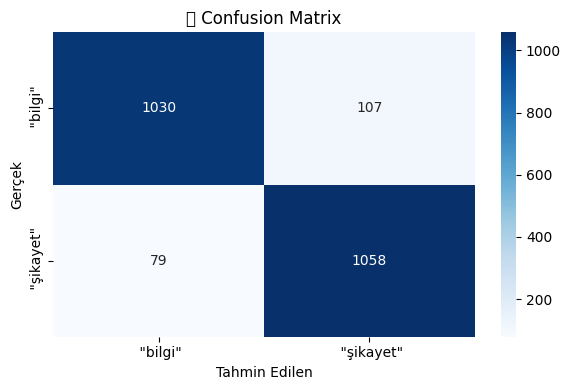

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)

import nltk
from nltk.corpus import stopwords

# === Stopwords indir ===
nltk.download("stopwords")
turkish_stopwords = stopwords.words("turkish")

# === Veri temizleme fonksiyonu ===
def emojileri_temizle(metin):
    emoji_pattern = re.compile(
        "[" u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002700-\U000027BF"
        u"\U0001F900-\U0001F9FF"
        u"\U0001FA70-\U0001FAFF"
        u"\U00002600-\U000026FF"
        u"\U000025A0-\U00002BEF"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', metin)

def temizle(metin):
    if not isinstance(metin, str):
        return ""
    metin = metin.lower()
    metin = re.sub(r"<.*?>", "", metin)
    metin = re.sub(r"http\S+|www\.\S+", "", metin)
    metin = emojileri_temizle(metin)
    metin = re.sub(r"[^\w\s]", "", metin)
    metin = re.sub(r"\s+", " ", metin)
    return metin

# === CSV dosyasını oku ===
df = pd.read_csv("niyet_verisi.csv", encoding="windows-1254", sep=",")

# === Geçersiz satırları temizle ===
df = df.dropna(subset=["text", "label"])
df = df[df["label"].apply(lambda x: isinstance(x, str))]

# === Temizleme işlemi ===
df["text"] = df["text"].apply(temizle)

# === Eğitim ve test verisine ayır ===
X = df["text"]
y = df["label"]

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === Dinamik max_features hesaplama ===
all_text = " ".join(X_train_raw)
kelime_frekanslari = Counter(all_text.split())
benzersiz_kelime_sayisi = len(kelime_frekanslari)
orani = 1
max_features_dinamik = int(len(kelime_frekanslari) * orani)
print(f"🔧 max_features (kararlı): {max_features_dinamik}")

# === TF-IDF Vektörleştirme ===
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95,
    min_df=1,
    ngram_range=(1, 3),
    max_features=max_features_dinamik,
    sublinear_tf=True,
    strip_accents='unicode',
    lowercase=True,
    stop_words=turkish_stopwords
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_raw)
X_test_tfidf = tfidf_vectorizer.transform(X_test_raw)

# === Geçerli etiketleri filtrele ===
valid_indices = y_train.apply(lambda x: isinstance(x, str)).to_numpy()
X_data = X_train_tfidf[valid_indices]
y_data = y_train[valid_indices].astype(str).to_numpy()

# Sınıf etiketlerini belirle
classes = np.unique(y_data)

# === Naive Bayes Modeli ===
model = MultinomialNB(alpha=0.05)

# === Eğitim Parametreleri ===
epochs = 200
batch_size = 128
epoch_accuracies = []

# === Eğitim Döngüsü ===
for epoch in range(epochs):
    print(f"📦 Epoch {epoch + 1}/{epochs}")
    indices = np.arange(X_data.shape[0])
    np.random.shuffle(indices)
    X_data = X_data[indices]
    y_data = y_data[indices]

    for i in range(0, X_data.shape[0], batch_size):
        X_batch = X_data[i:i + batch_size]
        y_batch = y_data[i:i + batch_size]
        if epoch == 0 and i == 0:
            model.partial_fit(X_batch, y_batch, classes=classes)
        else:
            model.partial_fit(X_batch, y_batch)

    y_pred_epoch = model.predict(X_data)
    epoch_acc = accuracy_score(y_data, y_pred_epoch)
    epoch_accuracies.append(epoch_acc)
    print(f"📈 Epoch {epoch + 1} Accuracy: {epoch_acc:.4f}")

# === Test İşlemi ===
y_pred = model.predict(X_test_tfidf)

results_df = pd.DataFrame({"y_test": y_test, "y_pred": y_pred})
results_df = results_df.dropna()
results_df = results_df[
    results_df["y_test"].apply(lambda x: isinstance(x, str)) &
    results_df["y_pred"].apply(lambda x: isinstance(x, str))
]

y_test_clean = results_df["y_test"]
y_pred_clean = results_df["y_pred"]

# === Değerlendirme Metikleri ===
print("\n🔍 Sınıflandırma Raporu:\n")
print(classification_report(y_test_clean, y_pred_clean, digits=4))

# === Metrikler ===
final_test_accuracy = accuracy_score(y_test_clean, y_pred_clean)
mean_train_accuracy = np.mean(epoch_accuracies)
macro_precision = precision_score(y_test_clean, y_pred_clean, average="macro")
macro_recall = recall_score(y_test_clean, y_pred_clean, average="macro")
macro_f1 = f1_score(y_test_clean, y_pred_clean, average="macro")

# === Metrik Tablosu ===
metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Test Set": [final_test_accuracy, macro_precision, macro_recall, macro_f1],
    "Train Set (Avg)": [mean_train_accuracy, None, None, None]
})

print(f"\n📊 Final Test Accuracy      : {final_test_accuracy:.4f}")
print(f"✅ Ortalama Eğitim Doğruluğu: {mean_train_accuracy:.4f}")
print(f"🎯 Macro Precision           : {macro_precision:.4f}")
print(f"📢 Macro Recall              : {macro_recall:.4f}")
print(f"🏁 Macro F1 Score            : {macro_f1:.4f}")
print("\n📋 Değerlendirme Özeti:")
print(metrics_df.to_string(index=False))

# === Confusion Matrix ===
cm = confusion_matrix(y_test_clean, y_pred_clean, labels=classes)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("🧩 Confusion Matrix")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.tight_layout()
plt.show()

In [36]:
def niyet_tahmini(cumle):
    cumle = temizle(cumle)
    vec = tfidf_vectorizer.transform([cumle])  # tfidf_vectorizer → modelin eğitildiği vektörizer
    tahmin = model.predict(vec)
    return tahmin[0]

# === Test ===
print(niyet_tahmini("Hayırsız."))  # Beklenen: Şikayet
print(niyet_tahmini("Fatura geldi."))  # Beklenen: Bilgi
print(niyet_tahmini("İlgilenmiyolar resmen ya."))  # Beklenen: Şikayet
print(niyet_tahmini("Ne zaman bi işim düşse, hep kayıplara karışıyo bu adam, bulamiyomki hiç."))  # Beklenen: Şikayet
print(niyet_tahmini("Dün de söyledim sana, gene aynı hatayı yapıyon işte, dinlemiyonki beni."))  # Beklenen: Şikayet
print(niyet_tahmini("iki artı iki dörttür."))  # Beklenen: Bilgi
print(niyet_tahmini("Beş para etmezsin."))  # Beklenen: Şikayet

 "şikayet"
 "bilgi"
 "şikayet"
 "şikayet"
 "şikayet"
 "bilgi"
 "şikayet"


In [37]:
# === Model ve Vectorizer'ı Kaydet ===
with open("chatbot_model.pkl", "wb") as f_model:
    pickle.dump(model, f_model)

with open("tfidf_vectorizer.pkl", "wb") as f_vect:
    pickle.dump(tfidf_vectorizer, f_vect)

print("💾 Model ve vektörleştirici kaydedildi.")

💾 Model ve vektörleştirici kaydedildi.


C:\Users\YIGITHAN\AppData\Local\Temp\ipykernel_10548\3359563436.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=df, palette="pastel")


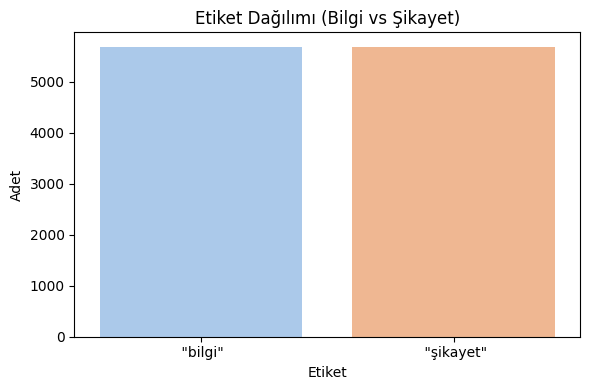

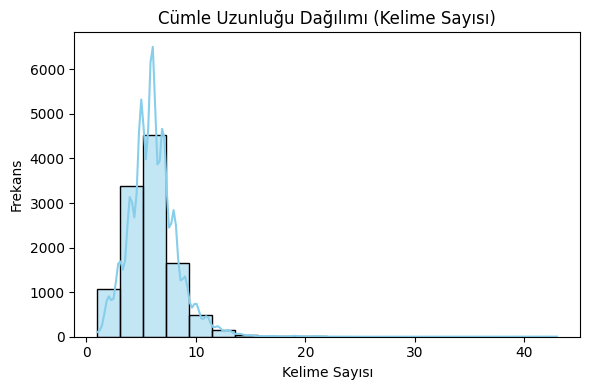

C:\Users\YIGITHAN\AppData\Local\Temp\ipykernel_10548\3359563436.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(frekanslar), y=list(kelimeler), palette="viridis")


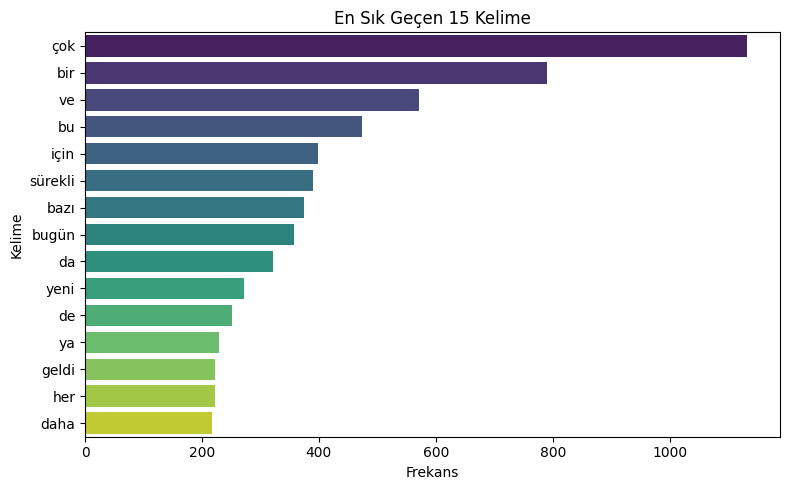

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

# Örnek veri yükleme (senin elindeki veri setini buraya oku)
# Örnek CSV formatı: iki sütun -> "metin", "etiket"
df = pd.read_csv("niyet_verisi.csv", encoding="windows-1254", sep=",")  # kendi dosya adını yaz

# 1. Etiket dağılımı
plt.figure(figsize=(6, 4))
sns.countplot(x="label", data=df, palette="pastel")
plt.title("Etiket Dağılımı (Bilgi vs Şikayet)")
plt.xlabel("Etiket")
plt.ylabel("Adet")
plt.tight_layout()
plt.show()

# 2. Cümle uzunluğu (kelime sayısına göre)
df["kelime_sayisi"] = df["text"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(6, 4))
sns.histplot(data=df, x="kelime_sayisi", bins=20, kde=True, color="skyblue")
plt.title("Cümle Uzunluğu Dağılımı (Kelime Sayısı)")
plt.xlabel("Kelime Sayısı")
plt.ylabel("Frekans")
plt.tight_layout()
plt.show()

# 3. En sık geçen kelimeler (tüm veri setinde)
def temizle_kelimeler(metin):
    metin = metin.lower()
    metin = re.sub(r"[^\w\s]", "", metin)
    return metin.split()

tum_kelimeler = []
df["text"].apply(lambda x: tum_kelimeler.extend(temizle_kelimeler(str(x))))

en_sik_kelimeler = Counter(tum_kelimeler).most_common(15)
kelimeler, frekanslar = zip(*en_sik_kelimeler)

plt.figure(figsize=(8, 5))
sns.barplot(x=list(frekanslar), y=list(kelimeler), palette="viridis")
plt.title("En Sık Geçen 15 Kelime")
plt.xlabel("Frekans")
plt.ylabel("Kelime")
plt.tight_layout()
plt.show()